In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        pass
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Necessary imports

In [75]:
import pandas as pd
import numpy as np
# import tensorflow as wtf  # just kidding
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image, ImageOps, ImageFilter
warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
import torch

!pip install --quiet vit-keras
from vit_keras import vit

TensorFlow Version 2.6.4


# Orange mission

## Simple binary classification: the image has error or not

### Static variables

In [90]:
from sklearn.model_selection import train_test_split
TRAIN_PATH: str = '/kaggle/input/eurecat-image-with-errors-b-dataset/B/data/'
train_df: pd.DataFrame = pd.read_csv(
    '/kaggle/input/eurecat-image-with-errors-b-dataset/B/train.csv', index_col=0)
# train_df['path'] = train_df['path'].apply(lambda x: "/".join(x.split('/')[3:]))

target_columns: str = list(train_df.columns[1:])  # status of the texture, with error or not
target_classes: list = len(target_columns)
train_df['path'] = train_df['image_path']

# columns_to_drop = list(train_df.columns[-6:])
# train_df[target_column] = train_df[columns_to_drop].apply(lambda x: target_classes[1] if np.sum(x.values) > 0 else target_classes[0], axis=1)
# train_df.drop(columns_to_drop, axis=1, inplace=True)

IMG_SIZE: tuple = Image.open(TRAIN_PATH + train_df['path'].iloc[0])._size
BATCH_SIZE: int = 6
    
train_df, test_df = train_test_split(train_df, test_size=0.2)
train_df, valid_df = train_test_split(train_df, test_size=0.4)  
train_df = pd.concat([train_df for _ in range(2)], axis=0)

train_df
# target_columns

,image_path,Taca oli,Carrera,Agujero,Hilo fino horizontal2,Tensión horizontal,Barrado,Borrissol,Hilo fino horizontal,Punto escapado,path
5064,9b5ec04e-frame0-00-12.23.jpg,0,0,0,0,0,0,0,0,0,9b5ec04e-frame0-00-12.23.jpg
6001,f78ded2f-frame0-00-18.82.jpg,0,0,0,0,0,0,0,1,0,f78ded2f-frame0-00-18.82.jpg
8887,e668360b-frame0-00-11.90.jpg,0,0,0,0,0,0,0,1,0,e668360b-frame0-00-11.90.jpg
11870,169f6d1a-frame0-00-06.48.jpg,0,1,0,0,0,0,0,0,0,169f6d1a-frame0-00-06.48.jpg
8862,91dfd57c-frame0-00-12.29.jpg,0,0,0,0,0,0,0,1,0,91dfd57c-frame0-00-12.29.jpg
...,...,...,...,...,...,...,...,...,...,...,...
354,bf26dd89-frame0-00-17.37.jpg,0,0,0,0,0,0,0,0,0,bf26dd89-frame0-00-17.37.jpg
3050,5fdffc87-frame0-00-42.71.jpg,1,0,0,0,0,0,0,0,0,5fdffc87-frame0-00-42.71.jpg
2115,c01a2516-frame0-00-18.78.jpg,0,0,0,0,0,0,0,0,0,c01a2516-frame0-00-18.78.jpg
3421,1c35f2ca-frame0-00-35.77.jpg,1,0,0,0,0,0,0,0,0,1c35f2ca-frame0-00-35.77.jpg


#### We synthetically duplicate the training dataframe to have more samples, avoiding overfitting using:
- Early stopping
- Data augmentation: i.e. is not probable the model sees 2 images duplicated; they suffer random transformations to make the model generalize better

# Data pipeline (TF with data augmentation)

### Data augmentation

In [91]:
def resizing(image: tf.image, _img_size: int = 768) -> tf.image:
    # We need to ensure all the images are squared... (for the transformer) 
    _img_shape: tuple = (_img_size, _img_size)
    image = tf.image.resize(image, _img_shape,
                            preserve_aspect_ratio=False, 
                            antialias=False, name=None)
    return image

def data_augmentation(image: tf.image) -> tf.image:
    """
    Based on random probabilities, perform different kind of augmenations on an image. 

    Parameters
    ----------
    images: tf.image
        Image corresponding to the set.

    Returns
    -------
    tf.image: An augmented image. 
        
            
    """

    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
    
    # We need to ensure all the images are squared... 
    image = resizing(image)
    
    return image

In [92]:
# from now on we can assume the images are squared 
# IMG_SIZE = (min(IMG_SIZE), min(IMG_SIZE))
IMG_SIZE = (768, 768)  # so that is multiple ot the 16/32 for the patches

# Data pipeline

## Training pipeline

### **Important**: the pre-trained models require images not scaled! That's why the option ``rescale = 1./255`` is missing in the ImageDataGenerator 

In [93]:
_train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center = True, samplewise_std_normalization = False,
    preprocessing_function = data_augmentation)
    
train_pipeline = _train_datagen.flow_from_dataframe(
    dataframe = train_df, directory=TRAIN_PATH, 
    x_col = 'path', y_col = target_columns, # subset='training',
    batch_size=BATCH_SIZE, seed=np.random.randint(50), color_mode='rgb',
    shuffle = True, class_mode = 'raw', target_size = IMG_SIZE)


_valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center = True, samplewise_std_normalization = False,
    preprocessing_function = resizing)
    
valid_pipeline = _valid_datagen.flow_from_dataframe(
    dataframe = valid_df, directory=TRAIN_PATH, 
    x_col = 'path', y_col = target_columns, # subset='validation',
    batch_size=BATCH_SIZE, seed=np.random.randint(50), color_mode='rgb',
    shuffle = True, class_mode = 'raw', target_size = IMG_SIZE)

_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center = True, samplewise_std_normalization = False,
    preprocessing_function = resizing)
    
test_pipeline = _test_datagen.flow_from_dataframe(
    dataframe = test_df, directory=TRAIN_PATH, 
    x_col = 'path', y_col = target_columns,
    batch_size=BATCH_SIZE, seed=np.random.randint(50), color_mode='rgb',
    shuffle = True, class_mode = 'raw', target_size = IMG_SIZE)

Found 5054 validated image filenames.
Found 1689 validated image filenames.
Found 1066 validated image filenames.


## We check it works by plotting some of the images

In [94]:
from PIL import Image
im = Image.open('/kaggle/input/eurecat-image-with-errors-b-dataset/B/data/000c1db9-frame0-00-07.03.jpg')
# im

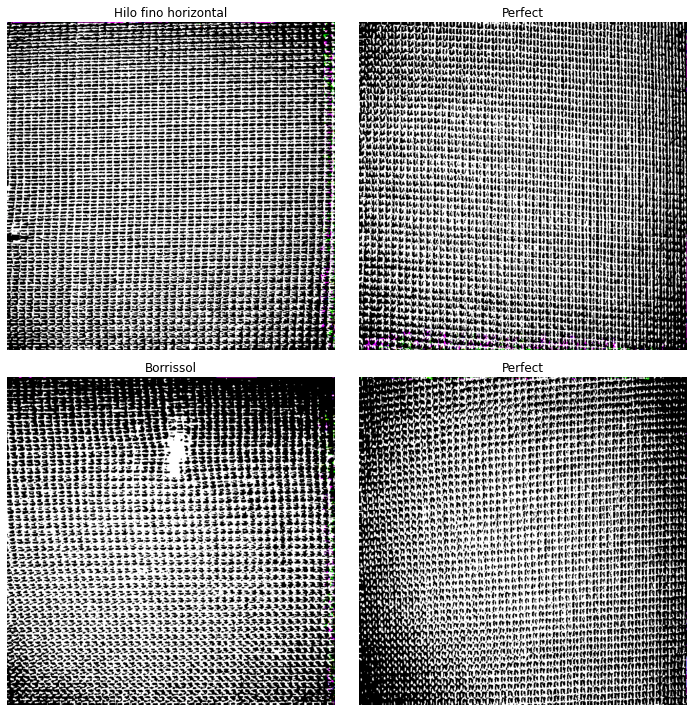

In [95]:
# Plot a grid of images.
PLOT_IMAGES = 4
images = []
labels_class = []

_image_j = PLOT_IMAGES
while _image_j > 0:
    _train_gen = train_pipeline

    _I_BATCH = np.random.randint(len(_train_gen) // BATCH_SIZE)
    i = np.random.randint(BATCH_SIZE)
    images.append(_train_gen[_I_BATCH][0][i]) # n Images from train generator.
    
    _class_index = np.argwhere(_train_gen[_I_BATCH][1][i] > 0).flatten()
    if len(_class_index) == 0:
        labels_class.append('Perfect')
    else:
        labels_class.append(target_columns[_class_index[0]]) # The correspondent name
    _image_j -= 1
    
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
axes = axes.flatten()

for img, ax, lab in zip(images, axes, labels_class):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(lab)
plt.tight_layout()
plt.show()

# Transformer training

## Import pretrained VIT model from Keras

In [96]:
def get_transformer_pretrained():
    pretrained_model = vit.vit_b16(
            image_size = IMG_SIZE[0],
            activation = 'sigmoid',
            pretrained = True,
            include_top = False,
            pretrained_top = False,
            classes = target_classes)
    pretrained_model.trainable = False

    model = tf.keras.Sequential([
                pretrained_model,
                tf.keras.layers.Flatten(),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(target_classes, activation = tfa.activations.gelu),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(target_classes, 'sigmoid')
            ], name = f'transfer_learning')
    return model

## Import pretrained CNN model from Keras

In [97]:
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras import layers

def get_cnn_pretrained(batch_normalization: bool = True, dropout_rate: float = 0.) -> tf.keras.Model:
    inputs = layers.Input(shape=(*IMG_SIZE, 3))
    pretrained_model = EfficientNetB6(include_top=False, input_tensor=inputs, weights="imagenet")
    # freeze the pretrained weights
    pretrained_model.trainable = False
    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(pretrained_model.output)
    
    if batch_normalization:
        x = layers.BatchNormalization()(x)  
    x = layers.Dropout(dropout_rate, name="top_dropout")(x)
    
    fcc_layer = layers.Dense(target_classes, activation="sigmoid", name="pred")
    outputs = fcc_layer(x)
    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    return model

### Alternatively, we built it from scratch

In [98]:
def get_cnn_scratch(batch_normalization: bool = True, dropout_rate: float = 0.) -> tf.keras.Sequential:
    model = tf.keras.Sequential([
        layers.Input(shape=(*IMG_SIZE, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(8, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(target_classes, activation="sigmoid"),], name = f'cnn_from_scratch')
    
    return model


In [99]:
model = get_cnn_scratch()
# model = get_transformer_pretrained()
# model.summary()  # it is really long in case of the pretrained CNN

## Compiling the model 

In [100]:
optimizer = 'adam'  # tfa.optimizers.RectifiedAdam(learning_rate=5e-2) # Creates the optimizer using rectified ADAM.
_loss_function = 'binary_crossentropy'  # tf.keras.losses.BinaryCrossentropy(from_logits=False)  # 'logloss'  # 'BCE'

In [101]:
model.compile(optimizer=optimizer, loss = _loss_function, metrics = ['accuracy', 'AUC'])

STEP_SIZE_TRAIN = train_pipeline.n // train_pipeline.batch_size
STEP_SIZE_VALID = valid_pipeline.n // valid_pipeline.batch_size

# Dynamic Learning Rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'min')
# Early stopping
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                 min_delta = 1e-4,
                                                 patience = 3,
                                                 mode = 'min',
                                                 restore_best_weights = True,
                                                 verbose = 1)
# Checkpoint. Save the model.
# checkpointer = tf.keras.callbacks.ModelCheckpoint(
#     filepath = '/kaggle/working/model.hdf5', monitor = 'val_accuracy', verbose = 1, 
#     save_best_only = True, save_weights_only = True, mode = 'max')

callbacks = [earlystopping, reduce_lr]  # , ]  # , checkpointer] # Our callbacks

## Training the model

In [ ]:
from tensorflow.keras.models import save_model
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
EPOCHS: int = 25
MODEL_NAME: str = 'cnn_scratch'  # 'transformed_vit16'  # 'cnn_from_scratch' 

history = model.fit(
    x=train_pipeline, steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_pipeline, validation_steps=STEP_SIZE_VALID,
    callbacks=callbacks, epochs=EPOCHS,  # EPOCHS,
    )

save_model(model, f'/kaggle/working/{MODEL_NAME}.h5')

Epoch 1/25
842/842 [==============================] - 415s 490ms/step - loss: 0.1514 - accuracy: 0.2748 - auc: 0.8681 - val_loss: 0.1386 - val_accuracy: 0.2871 - val_auc: 0.8990
Epoch 2/25
842/842 [==============================] - 390s 464ms/step - loss: 0.1421 - accuracy: 0.2843 - auc: 0.8837 - val_loss: 0.1370 - val_accuracy: 0.2906 - val_auc: 0.8925
Epoch 3/25
842/842 [==============================] - 379s 450ms/step - loss: 0.1389 - accuracy: 0.2880 - auc: 0.8891 - val_loss: 0.1329 - val_accuracy: 0.2900 - val_auc: 0.9098
Epoch 4/25
842/842 [==============================] - 386s 458ms/step - loss: 0.1278 - accuracy: 0.2938 - auc: 0.9106 - val_loss: 0.1231 - val_accuracy: 0.3072 - val_auc: 0.9247
Epoch 5/25
842/842 [==============================] - 377s 448ms/step - loss: 0.0931 - accuracy: 0.3552 - auc: 0.9411 - val_loss: 0.0561 - val_accuracy: 0.3974 - val_auc: 0.9696
Epoch 6/25
842/842 [==============================] - 370s 440ms/step - loss: 0.0501 - accuracy: 0.4865 - auc:

In [ ]:
plt.plot(history.history);

## Inference 

In [ ]:
pred=model.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)
predictions = (pred > 0.5).astype(int)
# columns = # ["desert", "mountains", "sea", "sunset", "trees"]
# columns should be the same order of y_col
# results=pd.DataFrame(predictions, columns=columns)
# results["Filenames"]=test_generator.filenames
# ordered_cols=["Filenames"]+columns
# results=results[ordered_cols]#To get the same column order
# results.to_csv("results.csv",index=False)

In [ ]:
from tensorflow.keras.models import load_model
# model = load_model('/kaggle/working/serialized.h5')
y_prob_train = model.predict(train_pipeline, steps = train_pipeline.n // train_pipeline.batch_size + 1)
y_prob_valid = model.predict(valid_pipeline, steps = valid_pipeline.n // valid_pipeline.batch_size + 1)
y_prob_test = model.predict(test_pipeline, steps = test_pipeline.n // test_pipeline.batch_size + 1)

## Result analysis & plots

In [ ]:
predicted_classes_train = np.argmax(y_prob_train, axis = 1)
predicted_classes_valid = np.argmax(y_prob_valid, axis = 1)
predicted_classes_test = np.argmax(y_prob_test, axis = 1)

# class_labels = list(true_pipeline.class_indices.keys())  

print('\n' + 3 * "---", 'TRAIN', 3 * '---')
print(classification_report(train_pipeline.classes, predicted_classes_train))
print('\n' + 3 * "---", 'VALIDATION', 3 * '---')
print(classification_report(valid_pipeline.classes, predicted_classes_valid))
print('\n' + 3 * "---", 'TEST', 3 * '---')
print(classification_report(test_pipeline.classes, predicted_classes_test))

### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#### Training

In [ ]:
confusionmatrix = confusion_matrix(train_pipeline.classes, predicted_classes_train)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
plt.savefig('/kaggle/working/cmatrix_train.png')

#### Validation

In [ ]:
confusionmatrix = confusion_matrix(valid_pipeline.classes, predicted_classes_valid)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
plt.savefig('/kaggle/working/cmatrix_validation.png')

#### Test

In [ ]:
confusionmatrix = confusion_matrix(test_pipeline.classes, predicted_classes_test)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
plt.savefig('/kaggle/working/cmatrix_test.png')

### ROC curve

In [ ]:
from sklearn import metrics

def compute_roc_and_auc(y_true,  y_pred_proba):
    fpr, tpr, _ = metrics.roc_curve(y_true,  y_pred_proba,)
    auc = metrics.roc_auc_score(y_true, y_pred_proba)
    return fpr, tpr, auc

In [ ]:
fpr_train, tpr_train, auc_train = compute_roc_and_auc(train_pipeline.classes, y_prob_train[:, 1])
fpr_valid, tpr_valid, auc_valid = compute_roc_and_auc(valid_pipeline.classes, y_prob_valid[:, 1])
fpr_test, tpr_test, auc_test = compute_roc_and_auc(test_pipeline.classes, y_prob_test[:, 1])

#create ROC curve
plt.plot(fpr_train, tpr_train, label=f"Train AUC="+str(auc_train))
plt.plot(fpr_valid, tpr_valid, label=f"Validation AUC="+str(auc_valid))
plt.plot(fpr_test, tpr_test, label=f"Test AUC="+str(auc_test))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.savefig('/kaggle/working/ROC.png')
plt.show()